# 1. Setup

## 1.1 Install Dependencies

In [54]:
%%capture var_that_contains_the_cell_output
import os
os.sys.path  # this is to know where the kernel is looking for packages

In [13]:
var_that_contains_the_cell_output.stdout

''

## 1.2 Import Dependencies

In [4]:
# Import standard dependencies
import tensorflow as tf   # ( heaviest of them all ; No need to run this cell when you are not working with tensorflow )

In [4]:
import random
import numpy as np

In [19]:
from matplotlib import pyplot as plt

In [18]:
import cv2

In [4]:
# use this to know if eerything is imported correctly

print("TensorFlow version:", tf.__version__)
print("OpenCV version:", cv2.__version__)

TensorFlow version: 2.16.1
OpenCV version: 4.9.0


In [ ]:
# Import tensorflow dependencies - Functional API
from tensorflow.keras.models import Model 

# Many types of layers :- Dense ( all neurons have acccess to ALL other neurons of the previous layer ) ; Con2D for IP 
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten

# Three most important things :- Model, Layer, Input
# Model(input=[input_image, verificaiton_image],output=[1,0]) <-- kinda how it works
# Input(shape=...)
# Flatten :- flattens the data from a CONVOLUTIONAL NN to a Dense Layer

## 1.3 Set GPU Growth

In [7]:
# You need to start using WSL2 for All DL projects if you want to use GPU
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [8]:
# By default tensor_flow expands to take entire VRAM := which can lead to out of memory (OOM) error 
# We impose a growth rate restriction on TensorFlow


# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

## 1.4 Create Folder Structures

In [19]:
# Get current working directory
os.getcwd()

'D:\\Code Practise\\Exploring__Open_CV__\\FaceRecognition'

In [56]:
# Setup paths
POS_PATH = os.path.join('data', 'positive')
NEG_PATH = os.path.join('data', 'negative')
ANC_PATH = os.path.join('data', 'anchor')

In [18]:
POS_PATH

'data\\positive'

In [16]:
# Make the directories
os.makedirs(POS_PATH)
os.makedirs(NEG_PATH)
os.makedirs(ANC_PATH)

# data
#   |----- positive
#   |----- negetive
#   |----- anchor

# 2. Collect Positives and Anchors

- Anchor Image ----> WebCam
- Positive Image --> WebCam US
- Negative Image --> LWF ( List of Wild Face )  Dataset

## 2.1 Untar Labelled Faces in the Wild Dataset

> I was able to have the path to be TAB completed while doing the `tar -xf`

In [3]:
! tar -xf lfw.tgz  

In [17]:
%%capture 
os.listdir('lfw')

In [18]:
# Move LFW Images to the following repository data/negative
for directory in os.listdir('lfw'):
    for file in os.listdir(os.path.join('lfw', directory)):
        EX_PATH = os.path.join('lfw', directory, file)
        NEW_PATH = os.path.join(NEG_PATH, file)
        os.replace(EX_PATH, NEW_PATH)

## 2.2 Collect Positive and Anchor Classes

### 2.2.1 Establish a connection to the webcam

In [95]:
# you could get cv2.cvtColor cpp error => you are accessing the wrong webcam
cap = cv2.VideoCapture(0)

while cap.isOpened(): 
    
    # frame is the image, ret is wheather success or not
    ret, frame = cap.read()

    # displaying frame
    cv2.imshow('Image Collection', frame)

    # Quit on pressing Q to exit gracefully ; No need of KeyboardInterrupt
    if cv2.waitKey(1) & 0XFF == ord('q'):
        break

# THIS IS WHAT YOU NEED TO EXECUTE when something goes wrong

# releases the webcame
cap.release()
# releases the image show frame
cv2.destroyAllWindows()

In [21]:
frame # it is JUST A NUMPY array !!!!!

array([[[136, 138, 148],
        [136, 139, 147],
        [141, 145, 146],
        ...,
        [255, 236, 162],
        [255, 240, 164],
        [255, 245, 169]],

       [[136, 139, 150],
        [138, 142, 150],
        [144, 149, 151],
        ...,
        [255, 237, 162],
        [255, 242, 165],
        [255, 246, 169]],

       [[137, 143, 152],
        [139, 146, 153],
        [145, 153, 153],
        ...,
        [255, 238, 163],
        [255, 241, 164],
        [255, 242, 163]],

       ...,

       [[120, 120,  20],
        [119, 119,  18],
        [119, 120,  17],
        ...,
        [108, 125, 141],
        [105, 124, 139],
        [103, 123, 138]],

       [[121, 121,  23],
        [119, 120,  20],
        [120, 121,  18],
        ...,
        [111, 128, 144],
        [108, 126, 142],
        [106, 124, 141]],

       [[123, 124,  27],
        [120, 122,  23],
        [120, 122,  19],
        ...,
        [114, 131, 147],
        [111, 129, 146],
        [109, 127, 144]]

In [22]:
# So my webcam by defaults gives 480x640 pixel image
frame.shape  

(480, 640, 3)

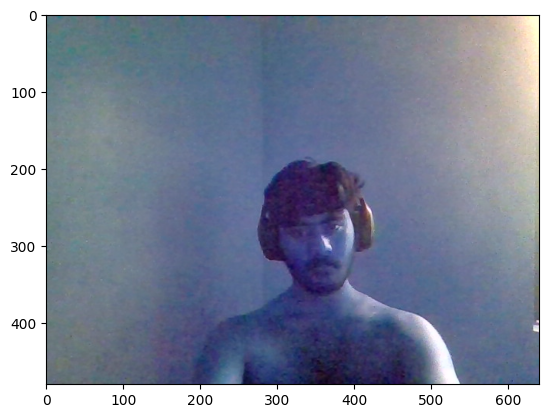

In [96]:
plt.imshow(frame) 

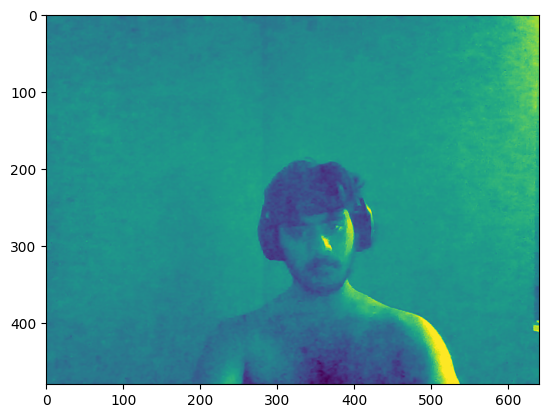

In [97]:
# the third parameter is essentially ---> WHICH COLOR CHANNEL to use
plt.imshow(frame[:,:,2])

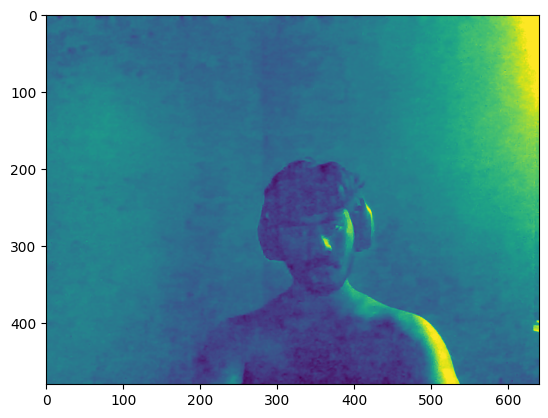

In [98]:
plt.imshow(frame[:,:,0])

In [51]:
new_frame = frame[:250, :250, : ] 
new_frame.shape  # frame[0:250, 0:250, 0:3 ].shape

(250, 250, 3)

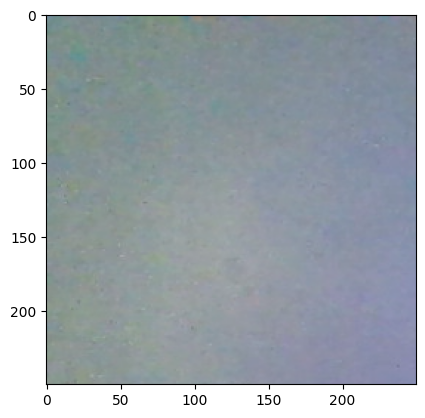

In [99]:
plt.imshow(new_frame) # essentially, just the TOP LEFT CORNER ; so we tweek this till it can reach our face

(250, 250, 3)


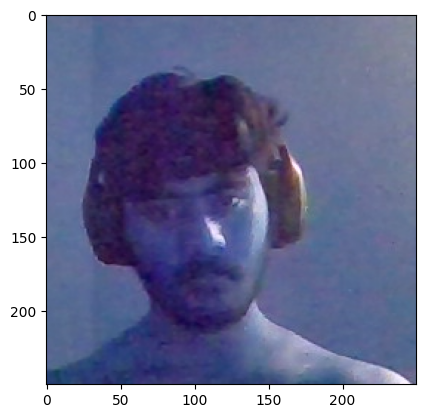

In [100]:
# now we want to adjust the slice that we wannt look for since ; we only need our face ;

# NOT THAT the first slice is Y-CORDINATE and second slice is X  CO-ORDINATE
# instead of [:250, :250, : ]  ===>  [y: y+250,  x: x+150,  :]  find (y,x)

# choose x,y from the scaling on plt.imshow() <------------ Main reason why plt is SOO USEFUL
# (480, 640) <--- total pixels [ therefore THE LAST COORDINATE (y_N, x_N) ]


y,x = 150, 250
correct_frame = frame[y: y+250, x: x+250, :]

print(correct_frame.shape)
plt.imshow(correct_frame)

### WebCam gives 250x250 pixel frames with ONLY the ROI ( Region Of Interest )

In [102]:
# you could get cv2.cvtColor cpp error => you are accessing the wrong webcam
cap = cv2.VideoCapture(0)

while cap.isOpened(): 
    
    # frame is the image, ret is wheather success or not
    ret, frame = cap.read()


    y,x = 150, 250
    correct_frame = frame[y: y+250, x: x+250, :]
    
    
    # displaying frame
    cv2.imshow('Image Collection', correct_frame)

    # Quit on pressing Q to exit gracefully ; No need of KeyboardInterrupt
    if cv2.waitKey(1) & 0XFF == ord('q'):
        break

# THIS IS WHAT YOU NEED TO EXECUTE when something goes wrong

# releases the webcame
cap.release()
# releases the image show frame
cv2.destroyAllWindows()

## Final code to get POS and ANCHOR from Webcam

In [90]:
# we need to NAME the generated files by a unique name ;
# often times we will be generating HUGE AMOUNT OF FILES 
# => automated way to uniquely name files ====> uuid()
import uuid

os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))

'data\\anchor\\f70d66cb-209d-11ef-a43a-f21805e91111.jpg'

In [94]:
cap = cv2.VideoCapture(0)

while cap.isOpened(): 
    ret, frame = cap.read()

    # Cut the frame down to 250 x 250 pixels ; Centered around where you're face is at
    y,x = 150, 250
    correct_frame = frame[y: y+250, x: x+250, :]
    
    # Collect anchors 
    if cv2.waitKey(1) & 0XFF == ord('a'):
        # Create the unique file path 
        imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out anchor image
        cv2.imwrite(imgname, correct_frame)
    
    # Collect positives
    if cv2.waitKey(1) & 0XFF == ord('p'):
        # Create the unique file path 
        imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out positive image
        cv2.imwrite(imgname, correct_frame)
    
    # Show image back to screen
    cv2.imshow('Image Collection', correct_frame)
    
    # Breaking gracefully
    if cv2.waitKey(1) & 0XFF == ord('q'):
        break

# Release the webcam
cap.release()
# Close the image show frame
cv2.destroyAllWindows()